In [30]:
# ## 0. 환경 설정 및 라이브러리 임포트

# %%
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import warnings
warnings.filterwarnings('ignore')

# RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors, Crippen, QED

# Chemprop
from chemprop import data, models, nn as chemprop_nn
from chemprop import featurizers
from chemprop.nn.metrics import ChempropMetric
from lightning import pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import TensorBoardLogger



# CheMeleon 모델 다운로드 (필요시)
from urllib.request import urlretrieve

# ML 라이브러리
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor, Pool

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 재현성을 위한 시드 설정
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

seed_everything(SEED, workers=True)


Seed set to 42


42

In [ ]:
# ## 1. Phase 1: 데이터 준비 및 특징 공학

# %%
# 데이터 로드
train_df = pd.read_csv('../data/train_dataset_with_3source.csv')
test_df = pd.read_csv('../data/test.csv')

test_df = test_df.rename(columns={'Smiles': 'SMILES'}) # train, test 컬럼명 불일치

print(f"Train 데이터: {train_df.shape}")
print(f"Test 데이터: {test_df.shape}")
print(f"\nTrain pIC50 분포:\n{train_df['pIC50'].describe()}")


Train 데이터: (2870, 3)
Test 데이터: (127, 2)

Train pIC50 분포:
count    2870.000000
mean        7.193166
std         1.128060
min         3.301030
25%         6.676935
50%         7.259640
75%         8.102370
max        13.000000
Name: pIC50, dtype: float64


In [32]:
def enumerate_smiles(smiles, num_versions=10):
    """하나의 SMILES에 대해 여러 버전의 SMILES를 생성합니다."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [smiles]
    
    # doRandom=True 옵션을 사용해 무작위 SMILES 생성
    return [Chem.MolToSmiles(mol, doRandom=True) for _ in range(num_versions)]

# 🔥 1. 중요: 증강 전에 고유 GroupID 할당
# 각 고유한 원본 분자에 ID를 부여합니다.
train_df['GroupID'] = range(len(train_df))

# --- Phase 1 데이터 준비 단계 마지막에 추가 ---
print("초고활성 분자 데이터 증강 (SMILES Enumeration)...")
high_activity_df = train_df[train_df['pIC50'] > 10].copy()
augmented_rows = []

NUM_VERSIONS = 3 # 현재 설정 유지

for _, row in high_activity_df.iterrows():
    original_smiles = row['SMILES']
    new_smiles_list = enumerate_smiles(original_smiles, num_versions=NUM_VERSIONS)
    
    for new_smiles in new_smiles_list:
        new_row = row.copy() # 🔥 row.copy()를 통해 GroupID가 자동으로 상속됩니다.
        new_row['SMILES'] = new_smiles
        augmented_rows.append(new_row)

# 원본 데이터와 증강된 데이터를 합침
augmented_df = pd.DataFrame(augmented_rows)
train_df = pd.concat([train_df, augmented_df], ignore_index=True)

print(f"데이터 증강 후 Train 데이터: {train_df.shape}")
# 이후 모든 학습은 train_df_augmented를 사용

초고활성 분자 데이터 증강 (SMILES Enumeration)...
데이터 증강 후 Train 데이터: (2921, 4)


In [ ]:
# RDKit 분자 특징 계산
def calculate_molecular_features(smiles):
    """분자 구조로부터 테이블 특징 추출"""
    features = {}
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        
        # 기본 분자 특성
        features['MolWt'] = Descriptors.MolWt(mol)
        features['LogP'] = Crippen.MolLogP(mol)
        features['NumHDonors'] = Lipinski.NumHDonors(mol)
        features['NumHAcceptors'] = Lipinski.NumHAcceptors(mol)
        features['NumRotatableBonds'] = Lipinski.NumRotatableBonds(mol)
        features['NumHeavyAtoms'] = Lipinski.HeavyAtomCount(mol)
        features['NumAromaticRings'] = Lipinski.NumAromaticRings(mol)
        features['TPSA'] = rdMolDescriptors.CalcTPSA(mol)
        features['QED'] = QED.qed(mol)
        
        # 추가 특징
        features['NumHeteroatoms'] = Lipinski.NumHeteroatoms(mol)
        features['RingCount'] = Lipinski.RingCount(mol)
        features['FractionCsp3'] = rdMolDescriptors.CalcFractionCSP3(mol)
        features['NumAliphaticRings'] = Lipinski.NumAliphaticRings(mol)
        features['NumSaturatedRings'] = Lipinski.NumSaturatedRings(mol)
               
        return features
    except Exception as e:
        print(f"Error processing SMILES '{smiles}': {e}") # 디버깅 시 사용
        return None

# Train 데이터 특징 계산
print("분자 특징 계산 중...")
train_features = []
for smiles in train_df['SMILES']:
    features = calculate_molecular_features(smiles)
    train_features.append(features)

train_tabular_features = pd.DataFrame(train_features)
train_df = pd.concat([train_df, train_tabular_features], axis=1)
train_df = train_df.dropna()  # 유효하지 않은 SMILES 제거

# Test 데이터 특징 계산
test_features = []
for smiles in test_df['SMILES']:
    features = calculate_molecular_features(smiles)
    test_features.append(features)

test_tabular_features = pd.DataFrame(test_features)
test_df = pd.concat([test_df, test_tabular_features], axis=1)
test_df = test_df.dropna()

print(f"\n유효한 Train 데이터: {train_df.shape}")
print(f"유효한 Test 데이터: {test_df.shape}")

분자 특징 계산 중...

유효한 Train 데이터: (2921, 18)
유효한 Test 데이터: (127, 16)


In [36]:
class CombinedBatchLoss(nn.Module):
    """
    Weighted MSE와 Correlation Loss를 배치 레벨에서 결합합니다.
    """
    def __init__(self, alpha=0.4, scaler=None, weight_configs={10: 5.0, 12: 20.0}):
        """
        alpha: WMSE의 비중 (대회 지표에 맞춰 0.4 권장)
        scaler: 데이터 정규화 스케일러
        weight_configs: {threshold: weight} 고활성 분자 가중치 설정
        """
        super().__init__()
        self.alpha = alpha
        self.scaler = scaler
        self.weight_configs = weight_configs

    def forward(self, preds, targets):
        # --- 1. 가중치 계산 ---
        if self.scaler is not None:
            # 원본 스케일로 복원 (가중치 계산을 위함). 디바이스 설정 중요.
            mean = torch.tensor(self.scaler.mean_[0], device=preds.device)
            std = torch.tensor(self.scaler.scale_[0], device=preds.device)
            targets_orig = targets * std + mean
        else:
            targets_orig = targets

        weights = torch.ones_like(targets)
        # 고활성 분자에 높은 가중치 적용 (10 이상 5배, 12 이상 20배)
        for threshold, weight in self.weight_configs.items():
            weights = torch.where(targets_orig > threshold, weight, weights)

        # --- 2. Weighted MSE (Batch Mean) ---
        mse = (preds - targets) ** 2
        weighted_mse = (mse * weights).mean() # 🔥 배치 평균 (스칼라)

        # --- 3. Correlation Loss (Batch Level) ---
        eps = 1e-8
        preds_m = preds - preds.mean()
        targets_m = targets - targets.mean()
        
        # Pearson Correlation (R) 계산
        cov = (preds_m * targets_m).sum()
        preds_std = torch.sqrt((preds_m ** 2).sum() + eps)
        targets_std = torch.sqrt((targets_m ** 2).sum() + eps)
        
        corr = cov / (preds_std * targets_std + eps)
        # 1 - R 사용
        corr_loss = 1.0 - torch.clamp(corr, -1.0, 1.0)

        # --- 4. 최종 손실 결합 ---
        total_loss = self.alpha * weighted_mse + (1 - self.alpha) * corr_loss
        
        # 로깅을 위해 개별 손실도 반환 (텐서 형태로 반환)
        return total_loss, weighted_mse, corr_loss

In [37]:
# Chemprop 데이터포인트 생성
def create_chemprop_datapoints(df, include_targets=True):
    """DataFrame을 Chemprop MoleculeDatapoint 리스트로 변환"""
    datapoints = []
    
    
    for idx, row in df.iterrows():
        smi = row['SMILES']
        
        if include_targets:
            pIC50_val = row['pIC50']
            
            datapoint = data.MoleculeDatapoint.from_smi(
                smi=smi,
                y=[pIC50_val]
            )
        else:
            datapoint = data.MoleculeDatapoint.from_smi(
                smi=smi
            )
        
        datapoints.append(datapoint)
    
    return datapoints

In [38]:
# 기존 Tier 관련 코드를 모두 삭제하고 아래 코드로 대체

# === 🔥 새로운 코드 (수동 Binning으로 교체) ===
def create_strat_key(df):
    # 1. pIC50 기반 수동 Binning 정의 (고활성 영역 명확히 분리)
    # Bins: <6, 6-8, 8-10, >10 (고활성)
    bins = [0, 6, 8, 10, 14] 
    labels = [f'bin_{i}' for i in range(len(bins)-1)]
    pIC50_binned = pd.cut(df['pIC50'], bins=bins, labels=labels, include_lowest=True)
    
    # 2. 출처와 Bin을 결합
    return df['source'] + '_' + pIC50_binned.astype(str)

train_df['strat_key'] = create_strat_key(train_df)

# 출처별로만 층화 추출
train_indices = np.arange(len(train_df))
train_idx, val_idx = train_test_split(
    train_indices,
    test_size=0.2,
    stratify=train_df['strat_key'], # 수정된 코드
    random_state=SEED
)

train_split_df = train_df.iloc[train_idx].reset_index(drop=True)
val_split_df = train_df.iloc[val_idx].reset_index(drop=True)

val_split_df_temp = train_df.iloc[val_idx]
print(f"\n--- 분할 검증 ---")
print(f"Val Max pIC50: {val_split_df_temp['pIC50'].max():.2f}")
# 분할 검증
print(f"Train split: {len(train_split_df)}, Val split: {len(val_split_df)}")
print(f"\nTrain 출처별 비율:\n{train_split_df['source'].value_counts(normalize=True)}")
print(f"\nVal 출처별 비율:\n{val_split_df['source'].value_counts(normalize=True)}")


--- 분할 검증 ---
Val Max pIC50: 13.00
Train split: 2336, Val split: 585

Train 출처별 비율:
source
CAS        0.938356
PubChem    0.035959
ChEMBL     0.025685
Name: proportion, dtype: float64

Val 출처별 비율:
source
CAS        0.936752
PubChem    0.037607
ChEMBL     0.025641
Name: proportion, dtype: float64


In [39]:
# Chemprop 모델 구축
# Message Passing 모듈 (분자 구조 인코딩)

# 1. CheMeleon Foundation Model 로드 및 featurizer 정의
if not os.path.exists("chemeleon_mp.pt"):
    urlretrieve(
        r"https://zenodo.org/records/15460715/files/chemeleon_mp.pt",
        "chemeleon_mp.pt",
    )

# Chemeleon 예제에 따라 featurizer와 mp 모듈 로드
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
chemeleon_mp_state = torch.load("chemeleon_mp.pt", weights_only=True)
mp = chemprop_nn.BondMessagePassing(**chemeleon_mp_state['hyper_parameters'])
mp.load_state_dict(chemeleon_mp_state['state_dict'])
print("Chemeleon Foundation Model 로드 완료.")

# 🔥 수정: CheMeleon은 freeze 옵션 추가
for param in mp.parameters():
    param.requires_grad = True # CheMeleon 가중치 고정
mp.eval()  # Dropout 등 비활성화

# 2. Chemprop 데이터셋 생성 (Featurizer 명시적 전달)
train_datapoints = create_chemprop_datapoints(train_split_df)
val_datapoints = create_chemprop_datapoints(val_split_df)

train_dset = data.MoleculeDataset(train_datapoints, featurizer=featurizer)
scaler = train_dset.normalize_targets()
val_dset = data.MoleculeDataset(val_datapoints, featurizer=featurizer)
val_dset.normalize_targets(scaler)

# 3. 데이터로더 생성
train_loader = data.build_dataloader(train_dset, batch_size=32, num_workers=0)
val_loader = data.build_dataloader(val_dset, batch_size=32, shuffle=False, num_workers=0)


Chemeleon Foundation Model 로드 완료.


In [ ]:
# 🔥 수정된 ImprovedChempropModule
class FineTunedChempropModule(pl.LightningModule):
    def __init__(self, model, loss_function, warmup_epochs=5, base_lr=5e-4, 
                 chemeleon_lr_factor=0.1, scaler=None):
        super().__init__()
        self.model = model
        self.loss_function = loss_function # 🔥
        self.warmup_epochs = warmup_epochs
        self.base_lr = base_lr
        self.chemeleon_lr_factor = chemeleon_lr_factor  # CheMeleon은 더 낮은 lr
        self.current_lr = base_lr
        self.scaler = scaler

        self.validation_step_outputs = []
        
        
    def forward(self, bmg, V_d=None, X_d=None):
        return self.model(bmg, V_d, X_d)
    

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        """
        trainer.predict() 호출 시 사용됩니다.
        batch 객체를 올바르게 해체하여 forward로 전달합니다.
        """
        # TrainingBatch 객체에서 필요한 구성 요소 추출
        bmg = batch.bmg
        
        # 추가 특징(V_d, X_d)이 있다면 처리 (안전한 접근을 위해 hasattr 사용)
        V_d = batch.V_d if hasattr(batch, 'V_d') else None
        X_d = batch.X_d if hasattr(batch, 'X_d') else None

        # 해체된 구성 요소로 forward 메서드 호출
        return self.forward(bmg, V_d, X_d)

    
    def training_step(self, batch, batch_idx):
        # Forward pass
        preds = self.forward(batch.bmg, batch.V_d, batch.X_d)
        # mask = torch.ones(preds.shape[0], dtype=torch.bool, device=preds.device)

        # 🔥 배치 레벨 손실 함수 사용
        loss, wmse_part, corr_part = self.loss_function(preds, batch.Y)

        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train/wmse_part', wmse_part, on_epoch=True)
        self.log('train/corr_part', corr_part, on_epoch=True)
        self.log('lr', self.current_lr, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        # 기존과 동일
        preds = self.forward(batch.bmg, batch.V_d, batch.X_d)
        loss, _, _ = self.loss_function(preds, batch.Y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

        # 🔥 검증 통계 확인을 위해 결과 저장 (정규화된 상태)
        self.validation_step_outputs.append({'preds': preds.detach(), 'targets': batch.Y.detach()})

        return loss
    
        # 🔥 on_validation_epoch_end 수정 (전체 통계 계산 및 출력)
    def on_validation_epoch_end(self):
        if not self.validation_step_outputs:
            return
        
        # 1. 전체 검증 배치 결과 집계
        all_preds_norm = torch.cat([x['preds'] for x in self.validation_step_outputs]).squeeze()
        all_targets_norm = torch.cat([x['targets'] for x in self.validation_step_outputs]).squeeze()
        
        # 2. 원본 스케일로 역변환 (통계 확인용)
        # 스케일러 값을 텐서로 변환하고 디바이스 맞추기
        mean = torch.tensor(self.scaler.mean_[0], device=self.device)
        std = torch.tensor(self.scaler.scale_[0], device=self.device)
        
        preds_orig = all_preds_norm * std + mean
        targets_orig = all_targets_norm * std + mean
        
        # 3. 전체 검증 데이터에 대한 통계 출력
        print(f"\n=== Epoch {self.current_epoch} Validation Summary (전체 배치) ===")
        print(f"Preds 범위:   [{preds_orig.min():.2f}, {preds_orig.max():.2f}]")
        # 이제 Targets 최대값이 13.0 근처로 보여야 합니다.
        print(f"Targets 범위: [{targets_orig.min():.2f}, {targets_orig.max():.2f}]") 
        print(f"예측 다양성 (std): {preds_orig.std():.3f}")
        
        # 4. 저장소 초기화
        self.validation_step_outputs.clear()
    
    
    def on_train_epoch_start(self):
        # Warmup logic
        if self.current_epoch < self.warmup_epochs:
            # Linear warmup
            lr = self.base_lr * 0.5 * (self.current_epoch + 1) / self.warmup_epochs
            self.current_lr = lr
            
            # 모든 param group에 적용
            for pg in self.optimizers().param_groups:
                if 'initial_lr' not in pg:
                    pg['initial_lr'] = pg['lr']
                pg['lr'] = pg['initial_lr'] * (self.current_epoch + 1) / self.warmup_epochs
            
            print(f"Warmup Epoch {self.current_epoch}: Base LR = {lr:.6f}")


    def on_train_epoch_end(self):
        # Update current_lr for logging
        self.current_lr = self.optimizers().param_groups[0]['lr']
        
        # 🔥 추가: 학습률 변화 모니터링
        if self.current_epoch % 10 == 0:
            print(f"\n=== 학습률 현황 (Epoch {self.current_epoch}) ===")
            for i, pg in enumerate(self.optimizers().param_groups):
                print(f"Param Group {i}: lr = {pg['lr']:.2e}")

    def configure_optimizers(self):
        # 🔥 차등 학습률 설정
        param_groups = []
        
        # CheMeleon 파라미터 (매우 낮은 학습률)
        chemeleon_params = []
        ffn_params = []
        
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                if 'message_passing' in name:  # CheMeleon 부분
                    chemeleon_params.append(param)
                else:  # FFN 부분
                    ffn_params.append(param)
        
        if chemeleon_params:
            param_groups.append({
                'params': chemeleon_params,
                'lr': self.base_lr * self.chemeleon_lr_factor,  # 0.01x
                'weight_decay': 1e-5
            })
        
        param_groups.append({
            'params': ffn_params,
            'lr': self.base_lr,
            'weight_decay': 5e-4
        })
        print(f"FFN params: {len(ffn_params)} tensors")

        
        # Optimizer
        optimizer = torch.optim.AdamW(
            param_groups,
            betas=(0.9, 0.999),
            eps=1e-8
        )
        
        # Scheduler - Cosine Annealing (미세조정에 적합)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=50,  # 50 epochs 주기
            eta_min=1e-6
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "frequency": 1
            }
        }

In [41]:
# 🔥 새로 추가: Lightning Module Wrapper
class ImprovedChempropModule(pl.LightningModule):
    def __init__(self, model, criterion, warmup_epochs=3, initial_lr=1e-4, scaler=None):
        super().__init__()
        self.model = model
        self.criterion = criterion  # 손실 함수 별도 전달
        self.warmup_epochs = warmup_epochs
        self.initial_lr = initial_lr
        self.current_lr = initial_lr
        self.scaler = scaler  # 🔥 scaler 추가

        # 🔥 추가: 손실 추적
        self.val_losses_per_sample = []
        
    def forward(self, bmg, V_d=None, X_d=None):
        # 모델은 예측값만 반환
        return self.model(bmg, V_d, X_d)
    
    def training_step(self, batch, batch_idx):
        # Forward pass - 예측값만 받음
        preds = self.forward(
            batch.bmg,
            batch.V_d,
            batch.X_d
        )

        mask = torch.ones(preds.shape[0], dtype=torch.bool, device=preds.device)

        # 🔥 여기에 추가! (첫 번째 에포크, 첫 번째 배치에서만)
        if self.current_epoch == 0 and batch_idx == 0:
            # output transform이 제대로 작동하는지 확인
            print(f"\n=== Output Transform 확인 ===")
            print(f"Scaler mean: {self.scaler.mean_[0]:.2f}, std: {self.scaler.scale_[0]:.2f}")
            print(f"정규화된 예측: {preds[:5].squeeze().tolist()}")
            
            # 수동으로 역변환
            manual_denorm = preds * self.scaler.scale_[0] + self.scaler.mean_[0]
            print(f"수동 역변환: {manual_denorm[:5].squeeze().tolist()}")
            
            # 타겟도 확인
            print(f"정규화된 타겟: {batch.Y[:5].squeeze().tolist()}")
            targets_denorm = batch.Y * self.scaler.scale_[0] + self.scaler.mean_[0]
            print(f"원본 타겟: {targets_denorm[:5].squeeze().tolist()}")

        
        # Loss 계산 - criterion 사용
        loss = self.criterion._calc_unreduced_loss(
            preds=preds,
            targets=batch.Y,
            mask=mask,  # mask 생성
            weights=batch.w if hasattr(batch, 'w') and batch.w is not None else torch.ones_like(batch.Y),
            lt_mask=batch.lt_mask if hasattr(batch, 'lt_mask') else torch.zeros_like(mask),
            gt_mask=batch.gt_mask if hasattr(batch, 'gt_mask') else torch.zeros_like(mask)
        )

        # 평균 계산
        loss = loss.mean()
        
        # Logging
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('lr', self.current_lr, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        # Forward pass - 예측값만 받음
        preds = self.forward(
            batch.bmg,
            batch.V_d,
            batch.X_d
        )

        # mask 생성
        mask = torch.ones(preds.shape[0], dtype=torch.bool, device=preds.device)
        
        # 🔥 개별 샘플별 손실 계산
        individual_losses = self.criterion._calc_unreduced_loss(
            preds=preds,
            targets=batch.Y,
            mask=mask,
            weights=batch.w if hasattr(batch, 'w') and batch.w is not None else torch.ones_like(batch.Y),
            lt_mask=batch.lt_mask if hasattr(batch, 'lt_mask') else torch.zeros_like(mask),
            gt_mask=batch.gt_mask if hasattr(batch, 'gt_mask') else torch.zeros_like(mask)
        )
        
        # 🔥 개별 손실 저장
        self.val_losses_per_sample.extend(individual_losses.detach().cpu().numpy())
        
        # 평균 계산
        loss = individual_losses.mean()
        
        # Logging
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

        
        # validation_step에 추가
        if batch_idx == 0:
            # 원본 스케일로 변환
            preds_orig = preds
            targets_orig = batch.Y * self.scaler.scale_[0] + self.scaler.mean_[0]
            
            print(f"\n원본 스케일:")
            print(f"Preds 범위: [{preds_orig.min():.1f}, {preds_orig.max():.1f}]")
            print(f"Targets 범위: [{targets_orig.min():.1f}, {targets_orig.max():.1f}]")
            print(f"예측 다양성: {preds.std():.3f}")
        
        return loss
    
    def on_validation_epoch_end(self):
        # 🔥 손실 분포 분석
        if self.val_losses_per_sample:
            losses = np.array(self.val_losses_per_sample)
            print(f"\n=== Val Loss 분석 ===")
            print(f"평균: {losses.mean():.2f}")
            print(f"중앙값: {np.median(losses):.2f}")
            print(f"최대값: {losses.max():.2f}")
            print(f"손실 > 10인 샘플 수: {(losses > 10).sum()}")
            print(f"손실 > 50인 샘플 수: {(losses > 50).sum()}")
            
            # 초기화
            self.val_losses_per_sample = []
    
    def on_train_epoch_start(self):
        # Warmup logic
        if self.current_epoch < self.warmup_epochs:
            # Linear warmup
            lr = self.initial_lr * 0.5 * (self.current_epoch + 1) / self.warmup_epochs
            self.current_lr = lr
            for pg in self.optimizers().param_groups:
                pg['lr'] = lr
            print(f"Warmup Epoch {self.current_epoch}: LR = {lr:.6f}")
    
    def configure_optimizers(self):
        # Optimizer
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.initial_lr,
            weight_decay=5e-4,
            betas=(0.9, 0.999),
            eps=1e-8  # 🔥 안정성 추가
        )
        
        # Scheduler - ReduceLROnPlateau
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.3,      # 0.5 → 0.3 (더 급격한 감소)
            patience=3,      # 그대로 유지
            threshold=0.01,  # 그대로 유지
            min_lr=1e-6,     # 추가: 최소 LR 설정
            cooldown=2,      # 추가: LR 변경 후 대기
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",  # 추가: 명시적 지정
                "interval": "epoch",
                "frequency": 1          # 추가: 매 epoch마다
            }
        }
    
    def on_train_epoch_end(self):
        # Update current_lr for logging
        self.current_lr = self.optimizers().param_groups[0]['lr']

In [42]:
# 4. 가중치 초기화 개선
def init_model_weights(module):
    if isinstance(module, nn.Linear):
        if module.out_features == 1:  # 최종 출력층
            # 평균 0 근처로 초기화 (정규화된 공간에서)
            nn.init.normal_(module.weight, mean=0.0, std=0.01)
            if module.bias is not None:
                # 타겟 평균값으로 초기화
                nn.init.constant_(module.bias, 0.0)  # 정규화된 평균은 0
        else:
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

In [43]:
pd.set_option('display.max_colwidth', 200)

# 학습 전에 데이터 확인
print(f"Train Y 범위: {train_dset.Y.min():.2f} ~ {train_dset.Y.max():.2f}")
print(f"Val Y 범위: {val_dset.Y.min():.2f} ~ {val_dset.Y.max():.2f}")
print(f"Train Y 평균: {train_dset.Y.mean():.2f}, 표준편차: {train_dset.Y.std():.2f}")
print(f"Val Y 평균: {val_dset.Y.mean():.2f}, 표준편차: {val_dset.Y.std():.2f}")

# 학습 전에 실행
print("\n=== 극단값 분석 ===")
print(f"Train pIC50 > 11: {(train_split_df['pIC50'] > 11).sum()}")
print(f"Val pIC50 > 11: {(val_split_df['pIC50'] > 11).sum()}")
print(f"Train pIC50 < 4: {(train_split_df['pIC50'] < 4).sum()}")
print(f"Val pIC50 < 4: {(val_split_df['pIC50'] < 4).sum()}")

# 극단값 샘플 보기
if (val_split_df['pIC50'] > 11).any():
    print("\nVal의 초고활성 샘플:")
    print(val_split_df[val_split_df['pIC50'] > 11][['SMILES', 'pIC50', 'source']])

# train과 val 데이터 분포 확인 (학습 전에 추가)
print(f"\nTrain pIC50 분포:")
print(f"  범위: [{train_split_df['pIC50'].min():.1f}, {train_split_df['pIC50'].max():.1f}]")
print(f"  평균: {train_split_df['pIC50'].mean():.1f}")
print(f"  고활성(>10) 샘플 수: {(train_split_df['pIC50'] > 10).sum()}")

print(f"\nVal pIC50 분포:")
print(f"  범위: [{val_split_df['pIC50'].min():.1f}, {val_split_df['pIC50'].max():.1f}]")
print(f"  평균: {val_split_df['pIC50'].mean():.1f}")
print(f"  고활성(>10) 샘플 수: {(val_split_df['pIC50'] > 10).sum()}")

Train Y 범위: -2.96 ~ 4.23
Val Y 범위: -2.22 ~ 4.23
Train Y 평균: 0.00, 표준편차: 1.00
Val Y 평균: 0.01, 표준편차: 1.00

=== 극단값 분석 ===
Train pIC50 > 11: 54
Val pIC50 > 11: 14
Train pIC50 < 4: 2
Val pIC50 < 4: 0

Val의 초고활성 샘플:
                                                          SMILES  pIC50 source
73       FC1(F)[C@@H](CC1)n1c(-c2cccc(NC(c3c(OC)nccc3)=O)n2)nnc1   13.0    CAS
102             COc1ncccc1C(=O)Nc1cccc(-c2nncn2[C@H]2CCC2(F)F)n1   13.0    CAS
140             c1cc(c(=O)[nH]c1)C(Nc1cccc(n1)-c1n(C(C)C)cnn1)=O   13.0    CAS
160      c1(OC)c(cccn1)C(Nc1cccc(n1)-c1n(C2(CC2)C(F)(F)F)cnn1)=O   13.0    CAS
178  N(c1nc(ccc1)-c1n([C@@H](C)C(F)(F)F)cnn1)C(c1cc(cnc1OC)Br)=O   13.0    CAS
180                  COc1ncc(Br)cc1C(=O)Nc1cccc(-c2nncn2C(C)C)n1   13.0    CAS
195                c1ccnc(OC)c1C(=O)Nc1nc(-c2nncn2C(C)C(F)F)ccc1   13.0    CAS
223             COc1ncccc1C(=O)Nc1cccc(-c2nncn2[C@@H](C)C(F)F)n1   13.0    CAS
313              n1cn(C(C)C(F)F)c(-c2cccc(n2)NC(c2cccnc2OC)=O)n1   13.0    CAS

In [ ]:
# 4. Chemprop 모델 구축
# Aggregation
agg = chemprop_nn.MeanAggregation()

# 🔥 손실 함수 인스턴스화 (WMSE 40%, CorrLoss 60%)
combined_loss_fn = CombinedBatchLoss(
    alpha=0.4, 
    scaler=scaler, 
    weight_configs={10: 5, 12: 10}
)


ffn = chemprop_nn.RegressionFFN(
    input_dim=mp.output_dim,  # CheMeleon의 출력 차원 사용 (2048)
    hidden_dim=1024,  # 300 → 1024
    n_layers=3,       # 2 → 3
    dropout=0.3,      # 0.0 → 0.1
)

# 새로 추가: FFN만 초기화 (CheMeleon은 제외)
ffn.apply(init_model_weights)

# 최종 MPNN 모델
model = models.MPNN(mp, agg, ffn, batch_norm=False)  # batch_norm=False 추가


# 🔥 수정: 미세조정용 Lightning Module 사용
lightning_model = FineTunedChempropModule(
    model=model,
    loss_function=combined_loss_fn, # 🔥 손실 함수 전달
    warmup_epochs=2,  # warmup 연장
    base_lr=3e-4,  # 기본 학습률 낮춤
    chemeleon_lr_factor=0.01,  # CheMeleon은 1/100 학습률
    scaler=scaler
)

# %%
# 모델 학습
print("Chemprop 모델 학습 중...")

# Logger 설정
logger = TensorBoardLogger(
    save_dir='./logs',
    name='chemprop_training',
    version='v1'
)

# 🔥 새로 추가: Callbacks
callbacks = [
    # Early Stopping
    EarlyStopping(
        monitor='val_loss',
        min_delta=0.0005,
        patience=15,
        verbose=True,
        mode='min',
        strict=True,       # 추가: 엄격한 모드
        check_finite=True  # 추가: NaN/Inf 체크
    ),
    # Learning Rate Monitor
    LearningRateMonitor(logging_interval='epoch'),
    # Model Checkpoint (최고 성능 모델 저장)
    ModelCheckpoint(
        monitor='val_loss',
        dirpath='./chemprop_finetuned_checkpoints',
        filename='chemprop-{epoch:02d}-{val_loss:.4f}',
        save_top_k=1,
        mode='min',
        save_weights_only=True
    )
]


trainer = pl.Trainer(
    max_epochs=150,  # 더 많은 epoch (early stopping이 있으므로)
    accelerator='auto',
    devices=1,
    enable_progress_bar=True,
    logger=logger,  # 또는 TensorBoardLogger 사용 가능
    enable_checkpointing=True,
    callbacks=callbacks,
    gradient_clip_val=0.5,  # Gradient clipping
    gradient_clip_algorithm='norm',
    deterministic=True,  # 재현성
    precision=32  # Mixed precision training (선택사항)
)

# 학습 실행
trainer.fit(lightning_model, train_loader, val_loader)


# 최고 성능 모델 로드
best_model_path = trainer.checkpoint_callback.best_model_path
if best_model_path:
    print(f"최고 성능 모델 로드: {best_model_path}")
    checkpoint = torch.load(best_model_path)
    lightning_model.load_state_dict(checkpoint['state_dict'])
    model = lightning_model.model  # 원래 모델 추출

    # 🔥 추가: 최고 모델을 별도로 저장
    torch.save({
        'model_state_dict': model.state_dict(),
        'scaler': scaler,
        'config': {
            'hidden_dim': 1024,
            'n_layers': 3,
            'dropout': 0.3
        }
    }, './best_chemprop_model.pt')

print("학습 완료!")

In [45]:
# ## 체크포인트에서 모델 로드 및 임베딩 추출

# 체크포인트 파일 경로
checkpoint_path = './best_chemprop_model.pt'

if os.path.exists(checkpoint_path):
    print(f"체크포인트 로드: {checkpoint_path}")
    
    # 체크포인트 로드
    checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu', weights_only=False)
    
    # 설정 정보 추출
    config = checkpoint.get('config', {
        'hidden_dim': 1024,
        'n_layers': 3,
        'dropout': 0.3
    })
    scaler = checkpoint['scaler']
    
    print(f"모델 설정: {config}")
    print(f"Scaler - mean: {scaler.mean_[0]:.3f}, std: {scaler.scale_[0]:.3f}")
    
    # 모델 재구성
    # 1. Featurizer
    featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
    
    # 2. CheMeleon MP 로드
    if os.path.exists("chemeleon_mp.pt"):
        chemeleon_mp_state = torch.load("chemeleon_mp.pt", weights_only=True)
        mp = chemprop_nn.BondMessagePassing(**chemeleon_mp_state['hyper_parameters'])
        mp.load_state_dict(chemeleon_mp_state['state_dict'])
        
        # Freeze
        for param in mp.parameters():
            param.requires_grad = True
        mp.eval()
    else:
        raise FileNotFoundError("CheMeleon 모델 파일이 없습니다: chemeleon_mp.pt")
    
    # 3. Aggregation
    agg = chemprop_nn.MeanAggregation()

    # 🔥 손실 함수 인스턴스화 (WMSE 40%, CorrLoss 60%)
    combined_loss_fn = CombinedBatchLoss(
        alpha=0.4, 
        scaler=scaler, 
        weight_configs={10: 5, 12: 10}
    )
    
    # 6. FFN
    ffn = chemprop_nn.RegressionFFN(
        input_dim=mp.output_dim,
        hidden_dim=config['hidden_dim'],
        n_layers=config['n_layers'],
        dropout=config['dropout'],
    )
    
    # 7. 전체 모델 구성
    model = models.MPNN(mp, agg, ffn, batch_norm=False)
    
    # 8. 체크포인트에서 가중치 로드
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Device 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    print("모델 로드 완료!")
    
else:
    raise FileNotFoundError(f"체크포인트 파일을 찾을 수 없습니다: {checkpoint_path}")

체크포인트 로드: ./best_chemprop_model.pt
모델 설정: {'hidden_dim': 1024, 'n_layers': 3, 'dropout': 0.3}
Scaler - mean: 7.290, std: 1.349
모델 로드 완료!


In [46]:
# 임베딩 추출 함수
def extract_embeddings(model, datapoints, featurizer_instance):
    """학습된 모델에서 분자 임베딩 추출"""
    embedding_dset = data.MoleculeDataset(datapoints, featurizer=featurizer_instance)
    loader = data.build_dataloader(
        embedding_dset,  # featurizer 전달
        batch_size=64, 
        shuffle=False, 
        num_workers=0
    )
    
    device = next(model.parameters()).device
    model.eval()

    # 추가: CheMeleon MP도 평가 모드 확인
    if hasattr(model, 'message_passing'):
        model.message_passing.eval()

    embeddings = []
    
    with torch.no_grad():
        for batch in loader:
            batch.bmg.to(device)
            if batch.V_d is not None:
                batch.V_d = batch.V_d.to(device)

            # FFN의 마지막 은닉층 출력을 임베딩으로 사용
            encoding = model.encoding(batch.bmg, batch.V_d, X_d=None, i=-1)
            embeddings.append(encoding.cpu().numpy())
    
    model.train()
    
    return np.concatenate(embeddings, axis=0)

# 전체 train 데이터의 임베딩 추출
all_train_datapoints = create_chemprop_datapoints(train_df)
train_embeddings = extract_embeddings(model, all_train_datapoints, featurizer)

# Test 데이터의 임베딩 추출
test_datapoints = create_chemprop_datapoints(test_df, include_targets=False)
test_embeddings = extract_embeddings(model, test_datapoints, featurizer)

print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")

# 🔥 새로 추가: 메모리 정리
import gc
torch.cuda.empty_cache()
gc.collect()

# 🔥 새로 추가: 체크포인트 디렉토리 정리 (선택사항)
import shutil

if os.path.exists('./chemprop_checkpoints'):
    # 최고 성능 모델만 유지하고 나머지 삭제
    print("체크포인트 정리 중...")
    shutil.rmtree('./chemprop_checkpoints')  # 필요시 주석 해제

Train embeddings shape: (2921, 1024)
Test embeddings shape: (127, 1024)


In [47]:
# ## 3. Phase 3: 최종 LightGBM 모델 학습

# %%
# 최종 특징셋 구축 (임베딩 + 테이블 특징)
feature_cols = ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 
               'NumRotatableBonds', 'TPSA', 'QED', 'NumHeteroatoms',
               'RingCount', 'FractionCsp3']

# 특징 정규화
from sklearn.preprocessing import StandardScaler as TabularScaler
feature_scaler = TabularScaler()
train_tabular_scaled = feature_scaler.fit_transform(train_df[feature_cols])
test_tabular_scaled = feature_scaler.transform(test_df[feature_cols])

# 임베딩과 테이블 특징 결합
X_train = np.hstack([train_embeddings, train_tabular_scaled])
y_train = train_df['pIC50'].values


X_test = np.hstack([test_embeddings, test_tabular_scaled])

print(f"최종 Train 특징 shape: {X_train.shape}")
print(f"최종 Test 특징 shape: {X_test.shape}")

최종 Train 특징 shape: (2921, 1034)
최종 Test 특징 shape: (127, 1034)


In [48]:
# Phase 3 시작 부분에 추가
def high_activity_mixup(X, y, high_activity_threshold=10, alpha=0.2, n_mixup_pairs=50):
    """
    고활성 분자끼리만 Mixup 수행
    
    Parameters:
    - X: 특징 행렬
    - y: 타겟 값
    - high_activity_threshold: 고활성 기준 (기본 10)
    - alpha: Beta 분포 파라미터 (작을수록 원본에 가까움)
    - n_mixup_pairs: 생성할 mixup 쌍의 수
    """
    high_mask = y > high_activity_threshold
    high_indices = np.where(high_mask)[0]
    
    print(f"  고활성 샘플 수: {len(high_indices)}")
    
    if len(high_indices) < 2:
        print("  고활성 샘플이 2개 미만이라 Mixup 불가")
        return X, y
    
    # 실제 생성할 mixup 수 결정
    n_pairs = min(n_mixup_pairs, len(high_indices) * 2)  # 너무 많이 만들지 않도록
    
    X_mixed = []
    y_mixed = []
    
    for _ in range(n_pairs):
        # 고활성 샘플 중에서 2개 선택
        idx1, idx2 = np.random.choice(high_indices, 2, replace=True)  # replace=True로 더 다양한 조합
        
        # Beta 분포에서 lambda 샘플링
        lam = np.random.beta(alpha, alpha)
        
        # 새로운 샘플 생성
        x_new = lam * X[idx1] + (1 - lam) * X[idx2]
        y_new = lam * y[idx1] + (1 - lam) * y[idx2]
        
        X_mixed.append(x_new)
        y_mixed.append(y_new)
    
    # 원본 데이터와 결합
    X_augmented = np.vstack([X, np.array(X_mixed)])
    y_augmented = np.hstack([y, np.array(y_mixed)])
    
    print(f"  Mixup으로 {n_pairs}개 샘플 추가")
    
    return X_augmented, y_augmented

In [49]:
# # ## Phase 3 추가: 다양한 모델 비교 평가

# # %%
# from catboost import CatBoostRegressor
# from sklearn.ensemble import ExtraTreesRegressor
# from sklearn.linear_model import Ridge
# from sklearn.neural_network import MLPRegressor
# from sklearn.model_selection import cross_val_predict
# import warnings
# warnings.filterwarnings('ignore')

# lgb_params = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'boosting_type': 'gbdt',
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'min_child_samples': 20,
#     'lambda_l1': 0.1,
#     'lambda_l2': 0.1,
#     'verbose': -1,
#     'min_gain_to_split': 0.01,
#     'max_bin': 255,
#     'min_data_in_bin': 3,
#     'feature_pre_filter': False
# }

# # 모델 정의
# models = {
#     'LightGBM': lgb.LGBMRegressor(
#         **lgb_params,
#         n_estimators=500,
#         random_state=SEED,
#         device='gpu',  # 🔥 GPU 사용
#     ),
    
#     'CatBoost': CatBoostRegressor(
#         iterations=500,
#         learning_rate=0.05,
#         depth=6,
#         l2_leaf_reg=3,
#         random_state=SEED,
#         verbose=False,
#         early_stopping_rounds=50,
#         task_type='GPU',  # 🔥 GPU 사용
#         devices='0'  # GPU ID
#     ),
    
#     'ExtraTrees': ExtraTreesRegressor(
#         n_estimators=300,
#         max_depth=15,
#         min_samples_split=20,
#         min_samples_leaf=10,
#         random_state=SEED,
#         n_jobs=-1
#     ),
    
#     'Ridge': Ridge(
#         alpha=1.0,
#         random_state=SEED
#     ),
    
#     'MLP': MLPRegressor(
#         hidden_layer_sizes=(512, 256, 128),
#         activation='relu',
#         alpha=0.001,
#         learning_rate='adaptive',
#         max_iter=500,
#         early_stopping=True,
#         validation_fraction=0.1,
#         random_state=SEED
#     )
# }

# # 대회 평가 지표 정확히 구현
# def competition_score(y_true, y_pred):
#     """대회 평가 지표 계산"""
#     # A: Normalized RMSE
#     rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#     y_range = y_true.max() - y_true.min()
#     normalized_rmse = rmse / y_range if y_range > 0 else rmse
#     A = 1 - min(normalized_rmse, 1)
    
#     # B: R² on pIC50 scale
#     B = r2_score(y_true, y_pred)
    
#     # Final score
#     score = 0.4 * A + 0.6 * B
    
#     return score, A, B


# # 평가 함수
# def evaluate_models(models, X_train, y_train, X_test, test_df, cv_folds=5):
#     """모델별 성능 평가 및 예측 분포 분석"""
#     results = {}
#     predictions = {}
#     test_predictions = {}  # 테스트 예측 저장
    
#     # 고활성 분자 인덱스 찾기
#     high_activity_mask = y_train > 10
#     very_high_mask = y_train > 11
    
#     print(f"전체 샘플 수: {len(y_train)}")
#     print(f"고활성(>10) 샘플 수: {high_activity_mask.sum()}")
#     print(f"초고활성(>11) 샘플 수: {very_high_mask.sum()}\n")
    
#     for name, model in models.items():
#         print(f"평가 중: {name}")
        
#         # Cross-validation 예측
#         if name == 'CatBoost':
#             # CatBoost는 별도 처리 (eval_set 때문)
#             oof_preds = np.zeros(len(X_train))
#             kf = KFold(n_splits=cv_folds, shuffle=True, random_state=SEED)
            
#             for train_idx, val_idx in kf.split(X_train):
#                 X_tr, X_val = X_train[train_idx], X_train[val_idx]
#                 y_tr, y_val = y_train[train_idx], y_train[val_idx]
                
#                 model.fit(X_tr, y_tr, eval_set=(X_val, y_val), verbose=False)
#                 oof_preds[val_idx] = model.predict(X_val)
#         else:
#             oof_preds = cross_val_predict(model, X_train, y_train, cv=cv_folds, n_jobs=-1)
        
#         # 전체 데이터로 학습 (test 예측용)
#         if name == 'CatBoost':
#             model.fit(X_train, y_train, verbose=False)
#         else:
#             model.fit(X_train, y_train)
        
#         # 🔥 Test 데이터 예측
#         test_preds = model.predict(X_test)
#         test_predictions[name] = test_preds
            
#         predictions[name] = oof_preds
        
#         # 성능 평가
#         rmse = np.sqrt(mean_squared_error(y_train, oof_preds))
#         r2 = r2_score(y_train, oof_preds)
        
#         # 고활성 분자에 대한 성능
#         high_rmse = np.sqrt(mean_squared_error(y_train[high_activity_mask], 
#                                              oof_preds[high_activity_mask]))
#         high_r2 = r2_score(y_train[high_activity_mask], 
#                           oof_preds[high_activity_mask]) if high_activity_mask.sum() > 1 else 0
        
#         # 예측 분포 통계
#         pred_stats = {
#             'mean': oof_preds.mean(),
#             'std': oof_preds.std(),
#             'min': oof_preds.min(),
#             'max': oof_preds.max(),
#             'above_10': (oof_preds > 10).sum(),
#             'above_11': (oof_preds > 11).sum()
#         }
        
#         # 🔥 Test 예측 통계 추가
#         test_stats = {
#             'mean': test_preds.mean(),
#             'std': test_preds.std(),
#             'min': test_preds.min(),
#             'max': test_preds.max(),
#             'above_10': (test_preds > 10).sum(),
#             'above_11': (test_preds > 11).sum()
#         }
        
#         results[name] = {
#             'RMSE': rmse,
#             'R2': r2,
#             'High_RMSE': high_rmse,
#             'High_R2': high_r2,
#             'Pred_Stats': pred_stats,
#             'Test_Stats': test_stats  # 추가
#         }
    
#     return results, predictions, test_predictions

# # 모델 평가 실행 (X_test와 test_df 전달)
# print("=== 모델 성능 비교 ===\n")
# results, predictions, test_predictions = evaluate_models(models, X_train, y_train, X_test, test_df)

# # 결과 출력 수정
# print("\n=== 전체 성능 요약 ===")
# for name, metrics in results.items():
#     print(f"\n{name}:")
#     print(f"  전체 RMSE: {metrics['RMSE']:.4f}, R2: {metrics['R2']:.4f}")
#     print(f"  고활성 RMSE: {metrics['High_RMSE']:.4f}, R2: {metrics['High_R2']:.4f}")
#     print(f"  OOF 예측 분포: mean={metrics['Pred_Stats']['mean']:.2f}, "
#           f"std={metrics['Pred_Stats']['std']:.2f}, "
#           f"range=[{metrics['Pred_Stats']['min']:.2f}, {metrics['Pred_Stats']['max']:.2f}]")
#     print(f"  OOF 예측 > 10: {metrics['Pred_Stats']['above_10']}개, "
#           f"예측 > 11: {metrics['Pred_Stats']['above_11']}개")
#     print(f"  \n🔥 Test 예측 분포: mean={metrics['Test_Stats']['mean']:.2f}, "
#           f"std={metrics['Test_Stats']['std']:.2f}, "
#           f"range=[{metrics['Test_Stats']['min']:.2f}, {metrics['Test_Stats']['max']:.2f}]")
#     print(f"  Test 예측 > 10: {metrics['Test_Stats']['above_10']}개, "
#           f"예측 > 11: {metrics['Test_Stats']['above_11']}개")



# # 핵심 분자 예측값 비교
# print("\n=== 핵심 분자 (TEST_015, 016, 017) 예측값 비교 ===")
# key_molecules = ['TEST_015', 'TEST_016', 'TEST_017']
# key_indices = test_df[test_df['ID'].isin(key_molecules)].index

# for name, test_preds in test_predictions.items():
#     print(f"\n{name}:")
#     for idx, mol_id in zip(key_indices, key_molecules):
#         pIC50_pred = test_preds[idx]
#         IC50_nM = 10 ** (9 - pIC50_pred)
#         print(f"  {mol_id}: pIC50 = {pIC50_pred:.2f}, IC50 = {IC50_nM:.1f} nM")
    
#     # 평균값
#     key_preds = test_preds[key_indices]
#     print(f"  평균 pIC50: {key_preds.mean():.2f}")




# # %%
# # 시각화: 모델별 예측 분포
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# axes = axes.flatten()

# for idx, (name, preds) in enumerate(predictions.items()):
#     ax = axes[idx]
    
#     # 산점도
#     scatter = ax.scatter(y_train, preds, alpha=0.5, s=20, c=y_train, cmap='viridis')
    
#     # 고활성 영역 표시
#     ax.axhline(y=10, color='red', linestyle='--', alpha=0.5, label='pIC50=10')
#     ax.axvline(x=10, color='red', linestyle='--', alpha=0.5)
#     ax.axhline(y=11, color='darkred', linestyle='--', alpha=0.5, label='pIC50=11')
#     ax.axvline(x=11, color='darkred', linestyle='--', alpha=0.5)
    
#     # 완벽한 예측선
#     ax.plot([y_train.min(), y_train.max()], 
#             [y_train.min(), y_train.max()], 'k--', alpha=0.5)
    
#     ax.set_xlabel('Actual pIC50')
#     ax.set_ylabel('Predicted pIC50')
#     ax.set_title(f'{name}\nRMSE={results[name]["RMSE"]:.3f}, R2={results[name]["R2"]:.3f}')
#     ax.set_xlim(3, 13)
#     ax.set_ylim(3, 13)
    
# # 마지막 subplot에 범례 추가
# axes[-1].axis('off')
# handles, labels = axes[0].get_legend_handles_labels()
# axes[-1].legend(['pIC50=10', 'pIC50=11', 'Perfect'], loc='center')

# plt.tight_layout()
# plt.show()

# # %%
# # 고활성 분자 예측 성능 상세 분석
# print("\n=== 고활성 분자 예측 상세 분석 ===")
# high_activity_actual = y_train[y_train > 10]
# very_high_activity_actual = y_train[y_train > 11]

# for name, preds in predictions.items():
#     high_preds = preds[y_train > 10]
#     very_high_preds = preds[y_train > 11]
    
#     print(f"\n{name}:")
#     print(f"  고활성(>10) 실제 {len(high_activity_actual)}개 중:")
#     print(f"    - 평균 예측: {high_preds.mean():.2f} (실제 평균: {high_activity_actual.mean():.2f})")
#     print(f"    - 정확히 >10으로 예측: {(high_preds > 10).sum()}개 ({(high_preds > 10).sum()/len(high_preds)*100:.1f}%)")
    
#     if len(very_high_activity_actual) > 0:
#         print(f"  초고활성(>11) 실제 {len(very_high_activity_actual)}개 중:")
#         print(f"    - 평균 예측: {very_high_preds.mean():.2f} (실제 평균: {very_high_activity_actual.mean():.2f})")
#         print(f"    - 정확히 >11로 예측: {(very_high_preds > 11).sum()}개 ({(very_high_preds > 11).sum()/len(very_high_preds)*100:.1f}%)")

# # %%
# # 최종 추천 모델 선정
# print("\n=== 최종 모델 추천 ===")

# # 대회 점수 계산
# for name in results:
#     y_pred = predictions[name]
#     comp_score, A, B = competition_score(y_train, y_pred)
#     results[name]['Competition_Score'] = comp_score
#     print(f"{name}: Competition Score = {comp_score:.4f} (A={A:.4f}, B={B:.4f})")

# # 최고 점수 모델
# best_model = max(results.items(), key=lambda x: x[1]['Competition_Score'])
# print(f"\n최고 성능 모델: {best_model[0]} (Score: {best_model[1]['Competition_Score']:.4f})")

In [ ]:
# CatBoost 하이퍼파라미터
cat_params = {
    'iterations': 500,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'random_state': SEED,
    'verbose': False,
    'early_stopping_rounds': 50,
    'task_type': 'GPU',  # GPU 사용시 'GPU'로 변경
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
}

# 가중치 계산 함수 정의
def calculate_sample_weights(y, high_weight=5.0, very_high_weight=15.0):
    weights = np.ones_like(y)
    weights[y > 10] = high_weight
    weights[y > 12] = very_high_weight
    return weights


# %%
from sklearn.model_selection import GroupKFold

# 5-Fold CV로 모델 성능 평가
gkf = GroupKFold(n_splits=5) 
groups = train_df['GroupID'].values # 🔥 Phase 1에서 생성한 그룹 정보 사용
cv_scores = []
cv_r2_scores = []
oof_predictions = np.zeros(len(X_train))

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_train, y_train, groups=groups)): # 변경
    print(f"\nFold {fold + 1}/5")
    
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    # 고활성 샘플만 Mixup 적용
    print(f"  Mixup 전: {len(X_tr)} 샘플")
    
    # 고활성 샘플끼리만 Mixup
    X_tr, y_tr = high_activity_mixup(
        X_tr, y_tr, 
        high_activity_threshold=10,  # pIC50 > 10
        alpha=0.2,  # 0.2 정도가 적당 (너무 작으면 원본과 너무 비슷)
        n_mixup_pairs=30  # fold 별로 30개 정도 생성
    )
    
    print(f"  Mixup 후: {len(X_tr)} 샘플")
    
    # CatBoost Pool 생성
    train_weights = calculate_sample_weights(y_tr)
    train_pool = Pool(X_tr, y_tr, weight=train_weights) # 🔥 weight 적용 확인
    val_pool = Pool(X_val, y_val)
    
    # 모델 학습
    model = CatBoostRegressor(**cat_params)
    model.fit(
        train_pool,
        eval_set=val_pool,
        verbose=100,
        plot=False
    )
    
    # 예측
    y_pred = model.predict(X_val)
    oof_predictions[val_idx] = y_pred
    
    # 평가
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    
    cv_scores.append(rmse)
    cv_r2_scores.append(r2)
    
    print(f"  RMSE: {rmse:.4f}, R2: {r2:.4f}")

print(f"\n평균 CV RMSE: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"평균 CV R2: {np.mean(cv_r2_scores):.4f} ± {np.std(cv_r2_scores):.4f}")

# 대회 평가 지표 정확히 구현
def competition_score(y_true, y_pred):
    """대회 평가 지표 계산"""
    # A: Normalized RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    y_range = y_true.max() - y_true.min()
    normalized_rmse = rmse / y_range if y_range > 0 else rmse
    A = 1 - min(normalized_rmse, 1)
    
    # B: R² on pIC50 scale
    B = r2_score(y_true, y_pred)
    
    # Final score
    score = 0.4 * A + 0.6 * B
    
    return score, A, B

# 대회 평가 지표로 최종 점수 계산
comp_score, A, B = competition_score(y_train, oof_predictions)
print(f"Competition Score: {comp_score:.4f} (A: {A:.4f}, B: {B:.4f})")


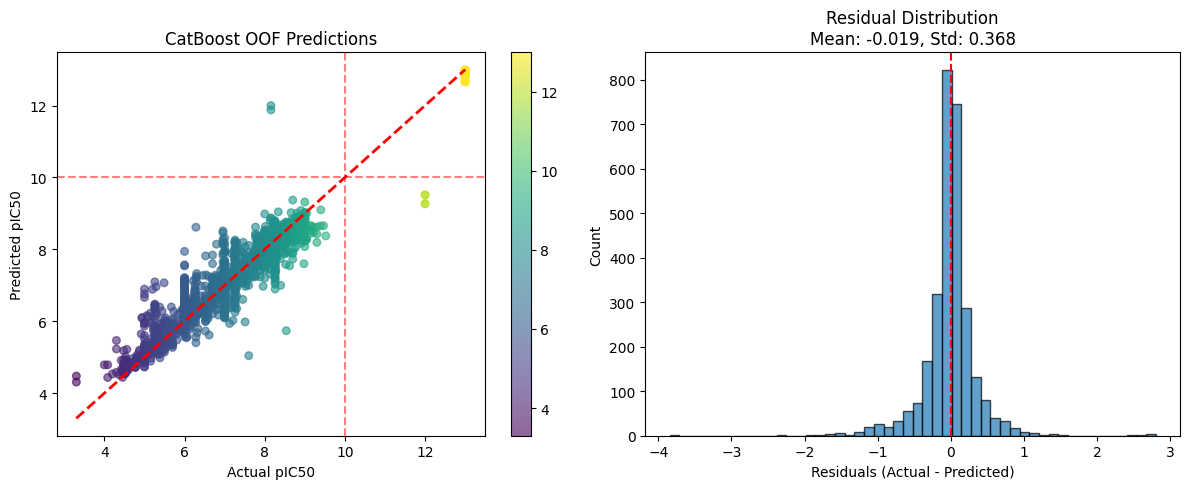

In [51]:
# OOF 예측 분석
plt.figure(figsize=(12, 5))

# 산점도
plt.subplot(1, 2, 1)
scatter = plt.scatter(y_train, oof_predictions, alpha=0.6, s=30, c=y_train, cmap='viridis')
plt.plot([y_train.min(), y_train.max()], 
         [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title('CatBoost OOF Predictions')
plt.colorbar(scatter)

# 고활성 영역 강조
plt.axhline(y=10, color='red', linestyle='--', alpha=0.5)
plt.axvline(x=10, color='red', linestyle='--', alpha=0.5)

# 잔차 분포
plt.subplot(1, 2, 2)
residuals = y_train - oof_predictions
plt.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Count')
plt.title(f'Residual Distribution\nMean: {np.mean(residuals):.3f}, Std: {np.std(residuals):.3f}')
plt.axvline(x=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

In [52]:
# 고활성 분자 예측 성능 확인
high_activity_mask = y_train > 10
very_high_mask = y_train > 11

print(f"\n고활성 분자 예측 성능:")
print(f"pIC50 > 10인 {high_activity_mask.sum()}개 중 {(oof_predictions[high_activity_mask] > 10).sum()}개 정확히 예측")
print(f"pIC50 > 11인 {very_high_mask.sum()}개 중 {(oof_predictions[very_high_mask] > 11).sum()}개 정확히 예측")



고활성 분자 예측 성능:
pIC50 > 10인 68개 중 64개 정확히 예측
pIC50 > 11인 68개 중 64개 정확히 예측


In [53]:
# ## 4. Phase 4: 최종 모델 학습 및 예측

# 전체 데이터로 최종 모델 학습
print("\n최종 CatBoost 모델 학습 중...")

# 전체 데이터에 고활성 Mixup만 적용
X_train_final = X_train.copy()
y_train_final = y_train.copy()

# 고활성 샘플끼리만 Mixup
X_train_final, y_train_final = high_activity_mixup(
    X_train_final, y_train_final,
    high_activity_threshold=10,
    alpha=0.2,
    n_mixup_pairs=200  # 전체 데이터니까 더 많이 생성
)

print(f"최종 학습 데이터: {len(X_train_final)} 샘플 (원본: {len(X_train)})")

# 🔥 최종 모델 학습 시에도 샘플 가중치 적용
final_weights = calculate_sample_weights(y_train_final)
train_pool_full = Pool(X_train_final, y_train_final, weight=final_weights) # 🔥 weight 적용 확인

# 최종 모델 학습
final_model = CatBoostRegressor(
    iterations=500,  # 전체 데이터이므로 더 많은 iteration
    learning_rate=0.03,  # 약간 낮춰서 세밀하게 학습
    depth=6,
    l2_leaf_reg=3,
    random_state=SEED,
    verbose=100,
    task_type='GPU'
)

final_model.fit(
    train_pool_full,
    verbose=100,
    plot=False
)

# Test 데이터 예측
test_pIC50_pred = final_model.predict(X_test)

# IC50(nM) 변환
test_IC50_nM = 10 ** (9 - test_pIC50_pred)

# %%
# 제출 파일 생성
submission_df = pd.DataFrame({
    'ID': test_df['ID'],
    'ASK1_IC50_nM': test_IC50_nM
})

# TEST_015, TEST_016, TEST_017 확인 (핵심 분자)
key_molecules = ['TEST_015', 'TEST_016', 'TEST_017']
key_predictions = submission_df[submission_df['ID'].isin(key_molecules)]
print("\n핵심 분자 예측값:")
print(key_predictions)
print(f"\n핵심 분자 평균 pIC50: {np.mean(9 - np.log10(key_predictions['ASK1_IC50_nM'])):.2f}")

# 전체 예측 분포 확인
predicted_pIC50 = 9 - np.log10(submission_df['ASK1_IC50_nM'])
print(f"\n예측 pIC50 분포:")
print(f"평균: {predicted_pIC50.mean():.2f}")
print(f"표준편차: {predicted_pIC50.std():.2f}")
print(f"최소값: {predicted_pIC50.min():.2f}")
print(f"최대값: {predicted_pIC50.max():.2f}")
print(f"pIC50 > 10 예측: {(predicted_pIC50 > 10).sum()}개")
print(f"pIC50 > 11 예측: {(predicted_pIC50 > 11).sum()}개")


# 제출 파일 저장
submission_df.to_csv('./submission_catboost.csv', index=False)
print(f"\n제출 파일 생성 완료: submission_catboost.csv")


최종 CatBoost 모델 학습 중...
  고활성 샘플 수: 68
  Mixup으로 136개 샘플 추가
최종 학습 데이터: 3057 샘플 (원본: 2921)
0:	learn: 2.8958283	total: 30.6ms	remaining: 15.3s
100:	learn: 0.2798333	total: 3.29s	remaining: 13s
200:	learn: 0.2288263	total: 6.44s	remaining: 9.58s
300:	learn: 0.2238719	total: 9.48s	remaining: 6.26s
400:	learn: 0.2202019	total: 12.1s	remaining: 2.98s
499:	learn: 0.2169878	total: 14.7s	remaining: 0us

핵심 분자 예측값:
          ID  ASK1_IC50_nM
15  TEST_015     73.749755
16  TEST_016    347.016285
17  TEST_017    321.035609

핵심 분자 평균 pIC50: 6.70

예측 pIC50 분포:
평균: 7.02
표준편차: 0.37
최소값: 6.12
최대값: 8.00
pIC50 > 10 예측: 0개
pIC50 > 11 예측: 0개

제출 파일 생성 완료: submission_catboost.csv


In [54]:
# 특징 중요도 확인
feature_importance = final_model.get_feature_importance()
feature_names = [f'embed_{i}' for i in range(train_embeddings.shape[1])] + feature_cols

# 상위 20개 중요 특징
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False).head(20)

print("\n상위 20개 중요 특징:")
print(importance_df)

# 모델 저장
final_model.save_model('./best_catboost_model.cbm')
print("\nCatBoost 모델 저장 완료: best_catboost_model.cbm")


상위 20개 중요 특징:
       feature  importance
256  embed_256   13.548380
949  embed_949    2.392741
615  embed_615    2.013314
549  embed_549    1.967821
586  embed_586    1.874971
760  embed_760    1.773071
347  embed_347    1.596760
985  embed_985    1.576410
779  embed_779    1.392938
964  embed_964    1.355329
696  embed_696    1.349123
612  embed_612    1.260969
233  embed_233    1.194739
289  embed_289    1.124038
622  embed_622    1.028937
600  embed_600    0.949193
912  embed_912    0.949150
251  embed_251    0.935441
839  embed_839    0.933032
294  embed_294    0.925142

CatBoost 모델 저장 완료: best_catboost_model.cbm
